# Baseline

## 1. Library Import

In [1]:
# 경고 필터링
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random, collections

import datetime
import dateutil.relativedelta

# 데이터 조작
import pandas as pd 
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [2]:
# import mlflow
# HOST = "http://localhost"
# mlflow.set_tracking_uri(HOST+":6006/")
# mlflow.start_run()

## 2. Fix Seed

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## 3. Function Definition

### 3.1. Generate Label

연월을 인자로 받아서 고객 ID별 총 구매액 `total`이 인자로 받는 임계값을 넘는지 여부를 이진 라벨로 생성한다.
- `year_month`의 총 구매액과 임계값이 넘는지 여부를 포함하는 데이터프레임 생성한다.
- 반환되는 데이터프레임은 year_month, customer_id, total, label 피처를 포함하며, year_month는 인자인 `year_month` 하나만 존재한다.
- 즉, `year_month`에 해당하는 월별 총 구매액만이 존재한다.

In [4]:
TOTAL_THRES = 300


In [5]:
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # order_date에서 연월을 추출하여 year_month 피처 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # 인자로 받은 연월 이전의 고객 ID 추출 (2009.12 - 2011.11)
    customers = df[df['year_month']<year_month]['customer_id'].unique()
    # 인자로 받은 연월의 데이터만 추출 (2011.12)
    df = df[df['year_month']==year_month]
    
    # 새로운 데이터프레임 생성
    df_label = pd.DataFrame({'customer_id':customers})
    df_label['year_month'] = year_month # 2011-12로 초기화
    
    # 각 고객 ID의 월별 구매액의 합 계산
    grouped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # grouped와 병합 후 임계값을 넘는지 여부에 따른 결과 label 피처 생성
    df_label = df_label.merge(grouped, on=['customer_id', 'year_month'], how='left')
    df_label['total'].fillna(0.0, inplace=True)
    df_label['label'] = (df_label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    df_label = df_label.sort_values('customer_id').reset_index(drop=True)

    # print_log가 True면 출력
    if print_log:
        print(f'{year_month} - final label shape: {df_label.shape}')
    
    return df_label

### 3.2. Print Evaluation Result
`prob_thres`를 기준으로 0과 1을 판별하고 precision, recall, f1-score, roc-auc 결과를 출력한다.

In [6]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

### 3.3. Preprocess
카테고리형 변수를 라벨 인코딩으로 숫자로 변환하고 결측치 중위값으로 채운다.

In [7]:
def preprocess(train, test, features, do_imputing=True):
    x_train = train.copy()
    x_test = test.copy()
    
    # 카테고리형 컬럼을 저장할 리스트
    category_columns = []

    for feature in features:
        # 문자열 피처를 라벨 인코딩
        if x_train[feature].dtype.name == 'object':
            category_columns.append(feature)
            le = LabelEncoder()
            # train과 test 데이터를 합쳐 모든 값을 고려
            # LabelEncoder가 이를 학습
            le.fit(list(x_train[feature].values) + list(x_test[feature].values))
            
            # train 데이터 레이블 인코딩 변환
            x_train[feature] = le.transform(list(x_train[feature].values))
            
            # test 데이터 레이블 인코딩 변환
            x_test[feature] = le.transform(list(x_test[feature].values))

    print('categorical feature:', category_columns)

    # 결측치가 있다면 중위값으로 채움
    if do_imputing:
        imputer = SimpleImputer(strategy='median')
        x_train[features] = imputer.fit_transform(x_train[features])
        x_test[features] = imputer.transform(x_test[features])
    
    return x_train, x_test

### 3.4. Feature Engineering
Aggregation 함수를 사용하여 여러 가지 피처를 생성한다.

In [8]:
def get_refund(is_refund, total):
    if is_refund:
        return -total
    return 0

In [9]:
CASES = ['POST', 'D', 'M', 'C2', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES', 'TEST001', 'TEST002', 'ADJUST', 'ADJUST2', 'SP1002']

def get_strange_product(product_id):
    if product_id in CASES:
        return True
    return False

In [10]:
def feature_engineering(df, year_month):
    df = df.copy()
    
    ################################ 피처 목록 ################################
    # time-series diff 피처 계산
    df['order_ts'] = df['order_date'].astype(np.int64)//1e9
    df['order_ts_diff'] = df.groupby(['customer_id'])['order_ts'].diff()
    df['quantity_diff'] = df.groupby(['customer_id'])['quantity'].diff()
    df['total_diff'] = df.groupby(['customer_id'])['total'].diff()

    # 환불
    df['is_refund'] = df.order_id.str.contains('C')
    df['refund_total'] = df.apply(lambda x:get_refund(x['is_refund'], x['total']), axis=1)

    # 이상한 product 소유 여부
    df['strange_product'] = df['product_id'].apply(get_strange_product)

    # month, year_month 피처
    df['month'] = df['order_date'].dt.month
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    ###########################################################################
    
    # year_month 이전 월 계산
    target_ym = datetime.datetime.strptime(year_month, "%Y-%m")             # year_month = '2011-12'
    prev_ym = target_ym - dateutil.relativedelta.relativedelta(months=1)    # prev_ym = '2011-11'
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train과 test 데이터 생성
    train = df[df['order_date'] < prev_ym]      # 2009-12부터 2011-10 데이터 추출
    test = df[df['order_date'] < year_month]    # 2009-12부터 2011-11 데이터 추출
    
    # train, test 라벨 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]     # 2011-11의 라벨
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]   # 2011-12의 라벨
    
    # groupby aggregation 함수 선언
    mode = lambda x:x.value_counts().index[0]
    agg_func = ['mean','max','min','sum','count','std','skew']
    agg_dict = {
        'total': agg_func,
        'order_id': ['nunique'],
        'product_id': ['nunique'],
        'order_ts': ['first', 'last'],
        'order_ts_diff': agg_func,
        'quantity_diff': agg_func,
        'total_diff': agg_func,
        'is_refund': ['sum'],
        'refund_total': ['sum', 'skew'],
        'strange_product': ['sum'],
        'month': [mode],
        'year_month': [mode],
    }

    # 새로운 데이터프레임 생성
    all_train_data = pd.DataFrame()
    
    # train 데이터에  aggregation 함수 적용해서 피처 생성
    train_agg = train.loc[train['order_date'] < prev_ym].groupby(['customer_id']).agg(agg_dict)

    new_cols = []
    for col in agg_dict.keys():
        for stat in agg_dict[col]:
            if type(stat) is str:
                new_cols.append(f'{col}-{stat}')
            else:
                new_cols.append(f'{col}-mode')

    train_agg.columns = new_cols
    train_agg.reset_index(inplace = True)
    
    train_agg['year_month'] = prev_ym
    
    all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_dict)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_train, x_test = preprocess(all_train_data, test_data, features)
    
    print('x_train.shape', x_train.shape, ', x_test.shape', x_test.shape)
    
    return x_train, x_test, all_train_data['label'], features

### 3.4. Train LightGBM Model with Out of Fold Method

In [11]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    features_train = train[features]
    features_test = test[features]
    
    test_preds = np.zeros(features_test.shape[0])      # test에 대한 예측 데이터를 저장할 변수
    y_oof = np.zeros(features_train.shape[0])          # Out Of Fold Validation 예측 데이터를 저장할 변수
    score = 0                                           # 폴드별 평균 Validation 스코어를 저장할 변수
    
    # 피처 중요도를 저장할 데이터 프레임 생성
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (train_idx, valid_idx) in enumerate(skf.split(features_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_train, x_valid = features_train.loc[train_idx, features], features_train.loc[valid_idx, features]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        print(f'fold: {fold+1}, x_train.shape: {x_train.shape}, x_valid.shape: {x_valid.shape}')

        # LightGBM 데이터셋 선언
        train_dataset = lgb.Dataset(x_train, label=y_train)
        valid_dataset = lgb.Dataset(x_valid, label=y_valid)
        
        # LightGBM 모델 학습
        clf = lgb.train(
            model_params,
            train_dataset,
            valid_sets=[train_dataset, valid_dataset], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_valid)
        
        # Validation index에 예측값 저장 
        y_oof[valid_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_valid, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_valid, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(features_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_train, x_valid, y_train, y_valid
        gc.collect()
        
    print(f"\nMean AUC = {score}")                  # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}")   # Out Of Fold Validation 스코어 출력
    
    # ###################### ML-FLOW ######################
    # mlflow.log_param("Model", "LightGBM")
    # mlflow.log_param("Folds", folds)
    # mlflow.log_param("Mean AUC", score)
    # mlflow.log_param("OOF AUC", roc_auc_score(y, y_oof))
    # #####################################################

    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

### 3.5. Train TabNet with Cross Validation

In [12]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch

In [33]:
def make_tabnet_skf_prediction(train, y, test, features, repeat=3, folds=10):
    features_train = train[features]
    features_test = test[features]
    
    test_preds = np.zeros(features_test.shape[0])      # test에 대한 예측 데이터를 저장할 변수
    y_oof = np.zeros(features_train.shape[0])          # Out Of Fold Validation 예측 데이터를 저장할 변수
    score = 0                                           # 폴드별 평균 Validation 스코어를 저장할 변수
    
    # 피처 중요도를 저장할 데이터 프레임 생성
    fi = pd.DataFrame()
    fi['feature'] = features
    
    clf = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),
        scheduler_params={"step_size":10, # how to use learning rate scheduler
                        "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='sparsemax' # This will be overwritten if using pretrain model
    )

    for i in range(repeat):
        print(f"Try {i} starts!")
        score = 0
        # Stratified K Fold 선언
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
        for fold, (train_idx, valid_idx) in enumerate(skf.split(features_train, y)):
            # train index, validation index로 train 데이터를 나눔
            x_train, x_valid = features_train.loc[train_idx, features], features_train.loc[valid_idx, features]
            y_train, y_valid = y[train_idx], y[valid_idx]
            
            print(f'fold: {fold+1}, x_train.shape: {x_train.shape}, x_valid.shape: {x_valid.shape}')

            clf.fit(
                X_train=x_train.values, y_train=y_train,
                eval_set=[(x_train.values, y_train), (x_valid.values, y_valid)],
                eval_name=['train', 'valid'], 
                eval_metric=['auc'],
            )

            # Validation 데이터 예측
            val_preds = clf.predict_proba(x_valid.values)[:, 1]
            
            # Validation index에 예측값 저장 
            y_oof[valid_idx] = val_preds
            
            # 폴드별 Validation 스코어 측정
            print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_valid, val_preds)}")
            print('-'*80)

            # score 변수에 폴드별 평균 Validation 스코어 저장
            score += roc_auc_score(y_valid, val_preds) / folds
            
            # 폴드별 피처 중요도 저장
            fi[f'fold_{fold+1}'] = clf.feature_importances_

            del x_train, x_valid, y_train, y_valid
            gc.collect()

        print(f"\nMean AUC = {score}")                  # 폴드별 Validation 스코어 출력
        print(f"OOF AUC = {roc_auc_score(y, y_oof)}")   # Out Of Fold Validation 스코어 출력
    
    # 테스트 데이터 예측
    test_preds = clf.predict_proba(features_test.values)[:, 1]

    # ###################### ML-FLOW ######################
    # mlflow.log_param("Model", "TabNet")
    # mlflow.log_param("Folds", folds)
    # mlflow.log_param("Mean AUC", score)
    # mlflow.log_param("OOF AUC", roc_auc_score(y, y_oof))
    # #####################################################
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

### 3.5. Plot Feature Importances

In [14]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

## 4. Load Train Data

In [15]:
data = pd.read_csv("../../input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## 5. 2010년 12월 데이터 확인하기

0    3699
1     637
Name: label, dtype: int64

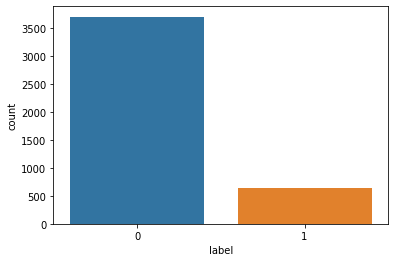

In [16]:
label_2010_12 = generate_label(data, '2010-12')['label']
sns.countplot(label_2010_12);
label_2010_12.value_counts()

## 6. Train Models

In [17]:
train, test, y, features = feature_engineering(data, '2011-12')

categorical feature: ['year_month-mode']
x_train.shape (5722, 41) , x_test.shape (5914, 41)


### 6.1. LightGBM

In [18]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

In [19]:
y_oof, test_preds_lgb, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

fold: 1, x_train.shape: (5149, 38), x_valid.shape: (573, 38)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	training's auc: 0.934165	valid_1's auc: 0.802225
Fold 1 | AUC: 0.802224854699589
--------------------------------------------------------------------------------
fold: 2, x_train.shape: (5149, 38), x_valid.shape: (573, 38)
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 1	valid_1's auc: 0.804502
Early stopping, best iteration is:
[105]	training's auc: 0.998554	valid_1's auc: 0.818791
Fold 2 | AUC: 0.8187909525043497
--------------------------------------------------------------------------------
fold: 3, x_train.shape: (5150, 38), x_valid.shape: (572, 38)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	training's auc: 0.926463	valid_1's auc: 0.833812
Fold 3 | AUC: 0.8338124393339805
-------------------------------------------------------

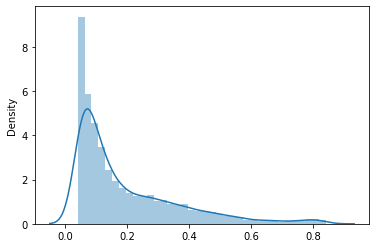

In [20]:
sns.distplot(test_preds_lgb)
plt.show()

0의 개수: 5505
1의 개수: 409


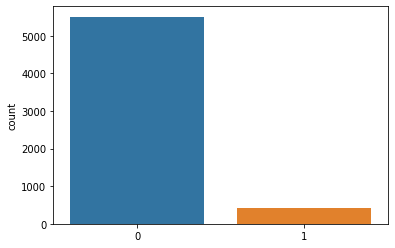

In [21]:
prob = [1 if x > 0.5 else 0 for x in test_preds_lgb]
counter = collections.Counter(prob)
for i, count in counter.items():
    print(f'{i}의 개수: {count}')
sns.countplot(prob)

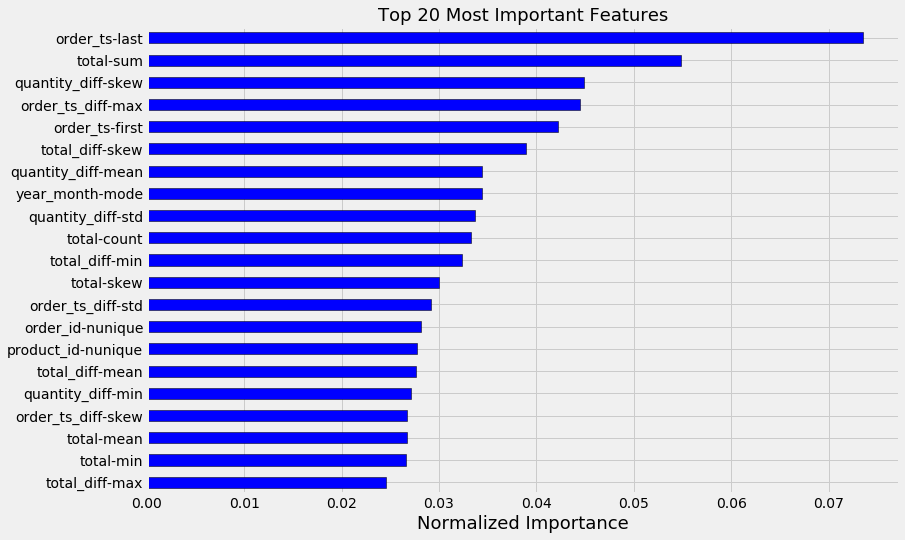

In [22]:
fi = plot_feature_importances(fi)

### 6.2. TabNet

In [38]:
y_oof, test_preds_tabnet, fi = make_tabnet_skf_prediction(train, y, test, features, repeat=4)

0.81568 | valid_auc: 0.83778 |  0:00:04s
epoch 4  | loss: 0.40187 | train_auc: 0.81629 | valid_auc: 0.83585 |  0:00:05s
epoch 5  | loss: 0.40199 | train_auc: 0.8159  | valid_auc: 0.83622 |  0:00:06s
epoch 6  | loss: 0.39927 | train_auc: 0.81557 | valid_auc: 0.83301 |  0:00:07s
epoch 7  | loss: 0.39803 | train_auc: 0.81557 | valid_auc: 0.8365  |  0:00:08s
epoch 8  | loss: 0.39961 | train_auc: 0.81543 | valid_auc: 0.83501 |  0:00:08s
epoch 9  | loss: 0.40377 | train_auc: 0.81538 | valid_auc: 0.83522 |  0:00:09s
epoch 10 | loss: 0.40407 | train_auc: 0.81504 | valid_auc: 0.83549 |  0:00:10s
epoch 11 | loss: 0.40126 | train_auc: 0.815   | valid_auc: 0.83564 |  0:00:11s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_valid_auc = 0.83956
Best weights from best epoch are automatically used!
Fold 9 | AUC: 0.8395570148589238
--------------------------------------------------------------------------------
fold: 10, x_train.shape: (5150, 38), x_valid.shape: (572, 38)
epoch 0  | l

In [1]:
sns.distplot(test_preds_tabnet)
plt.show()

NameError: name 'sns' is not defined

1의 개수: 583
0의 개수: 5331


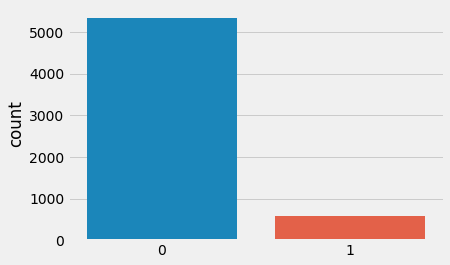

In [36]:
prob = [1 if x > 0.5 else 0 for x in test_preds_tabnet]
counter = collections.Counter(prob)
for i, count in counter.items():
    print(f'{i}의 개수: {count}')
sns.countplot(prob)

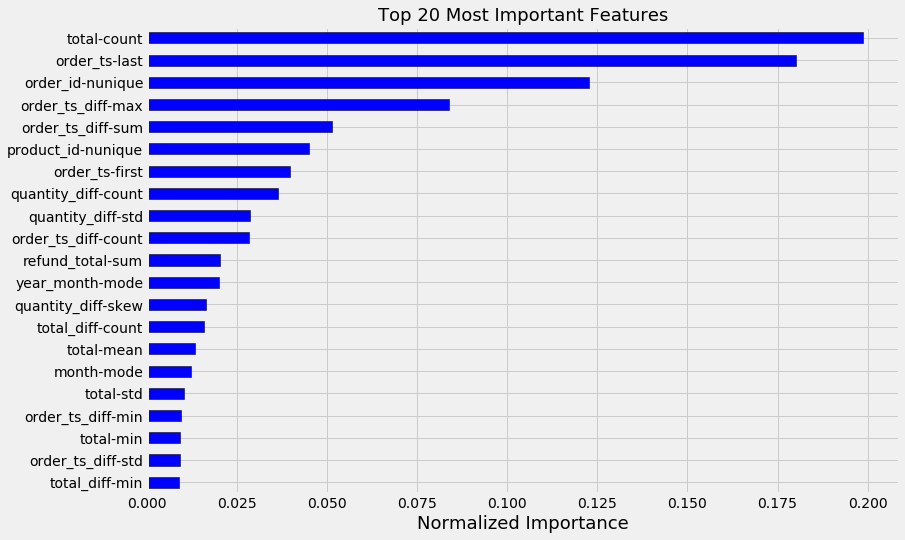

In [37]:
fi = plot_feature_importances(fi)

### 6.3. Soft Voting

In [27]:
test_preds = (test_preds_lgb + test_preds_tabnet) / 2

1의 개수: 342
0의 개수: 5572


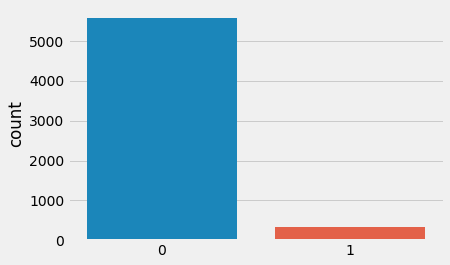

In [28]:
prob = [1 if x > 0.5 else 0 for x in test_preds]
counter = collections.Counter(prob)
for i, count in counter.items():
    print(f'{i}의 개수: {count}')
sns.countplot(prob)

## 7. Submission

In [29]:
output_dir = '../../output'
os.makedirs(output_dir, exist_ok=True)
submission = pd.read_csv('../../input/sample_submission.csv')
submission['probability'] = test_preds

now = datetime.datetime.now()
submission.to_csv(os.path.join(output_dir, f'output_{now.strftime("%Y%m%d%H%M%S")}.csv'), index=False)